### Cost Benefit Questions

1. How would you rephrase the business problem if your model was optimizing toward _precision_? i.e., How might the model behave differently, and what effect would it have?
2. How would you rephrase the business problem if your model was optimizing toward _recall_?
3. What would the most ideal model look like in this case?

Answers:

1. If this model where optimized toward precision, we'd be minimizing the number of false positives: users who are targeted in the campaign but are not retained.
2. If this model where optimized toward recall, we'd be minimizing the number of false negatives, or making sure that users who could have retained, did.
3. The model would be most optimized, at this point, towards recall, as there's the largest business gain.

### Visualizing models over variables

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../dataset/flight_delays.csv')
df = df.loc[df.DEP_DEL15.notnull()].copy()

In [3]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214.0,0.0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754.0,1.0,NaN


In [4]:
df = df[df.DEP_DEL15.notnull()]
df = df.join(pd.get_dummies(df['CARRIER'], prefix='carrier'))
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
model = lm.LogisticRegression()
features = [i for i in df.columns if 'dow_' in i]

In [5]:
df.shape

(458311, 37)

In [6]:
features += ['CRS_DEP_TIME']
model.fit(df[features[1:]], df['DEP_DEL15'])

df['probability'] = model.predict_proba(df[features[1:]]).T[1]

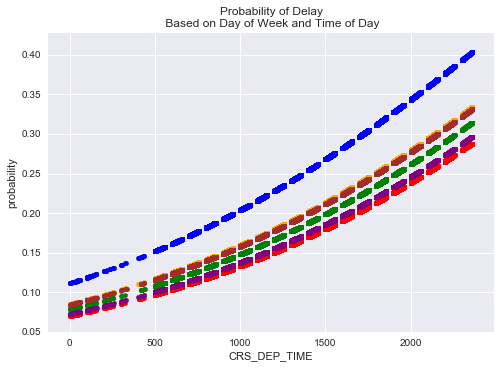

In [7]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax)

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')


### Other Answers: visualizing Airline performance over time; visualizing the inverse

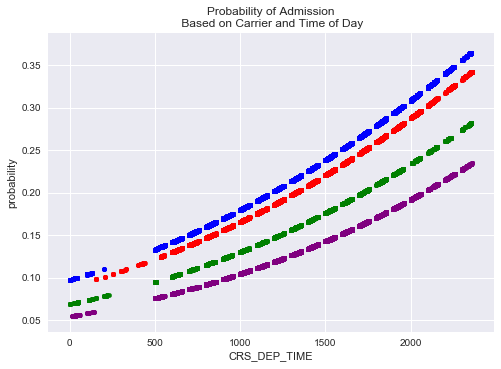

In [8]:
features = [i for i in df.columns if 'carrier_' in i]
features += ['CRS_DEP_TIME']
model = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])

df['probability'] = model.predict_proba(df[features[1:]]).T[1]

ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax)

    
ax.set(title='Probability of Admission\n Based on Carrier and Time of Day')

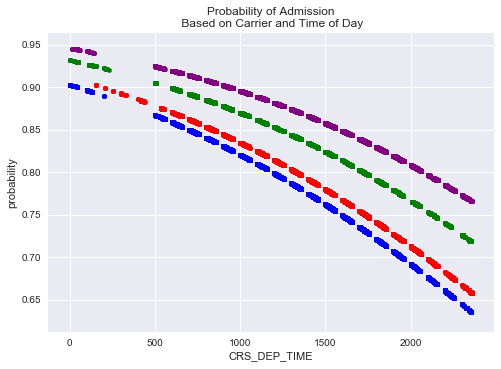

In [9]:
features = [i for i in df.columns if 'carrier_' in i]
features += ['CRS_DEP_TIME']
model = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])

df['probability'] = model.predict_proba(df[features[1:]]).T[0]

ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax)

    
ax.set(title='Probability of Admission\n Based on Carrier and Time of Day')

### Visualizing Performance Against Baseline

#### Visualizing AUC and comparing Models

In [10]:
from sklearn import dummy, metrics

In [11]:
model0 = dummy.DummyClassifier()
model0.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_0'] = model0.predict_proba(df[features[1:]]).T[1]

model1 = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_1'] = model.predict_proba(df[features[1:]]).T[1]


In [12]:
df.shape

(458311, 40)

[(0, 1),
 (0, 1),

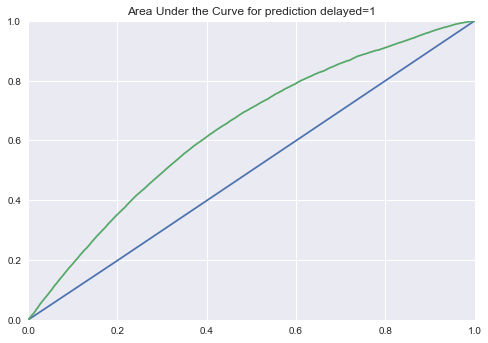

In [13]:
ax = plt.subplot(111)
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_1)
ax.plot(vals[0], vals[1])

ax.set(title='Area Under the Curve for prediction delayed=1', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

#### Visualizing Precision / Recall (with cleaner code)

In [14]:

model0 = dummy.DummyClassifier()
model0.fit(df[features[1:]], df.DEP_DEL15)
df['probability_0'] = model0.predict_proba(df[features[1:]]).T[1]


model = lm.LogisticRegression()
model.fit(df[features[1:]], df.DEP_DEL15)
df['probability_1'] = model.predict_proba(df[features[1:]]).T[1]


[(0, 1),
 (0, 1),

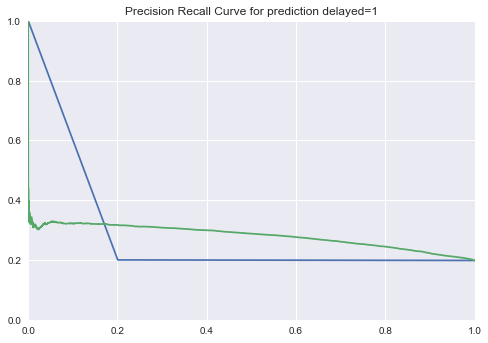

In [15]:
ax = plt.subplot(111)
for i in range(2):
    vals = metrics.precision_recall_curve(df.DEP_DEL15, df['probability_' + str(i)])
    ax.plot(vals[1], vals[0])

ax.set(title='Precision Recall Curve for prediction delayed=1', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))